## 03-Activation functions & Optimizers

[1.Sigmoid](#1)
  - [1-1.Zero Center](#1-1)
  - [1-2.Vanishing Gradient](#1-2)  


[2.Tanh](#2)  


[3.ReLU](#3)  

[4.Stochastic Gradient Descent](#4)
  - [4-1.Load Dataset](#4-1)
  - [4-2.Forward & Backward with Mini-Batch](#4-2)

[5.SGD+Momentum](#5)

[6.Adagrad](#6)

[7.RMSProp](#7)

[8.Adam](#8)
  

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
X, Y = make_moons(n_samples=5000, noise=0.2, random_state=42)
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)

# Y 레이블을 (n, 1) 형태로 변환
train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

# 넘파이 배열로 변환
train_x = train_x.T
train_y = train_y.T
test_x = test_x.T
test_y = test_y.T

# 데이터 형태 확인
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)

train_x shape: (2, 4000)
train_y shape: (1, 4000)
test_x shape: (2, 1000)
test_y shape: (1, 1000)


<a id="1"></a>
## 1.Sigmoid

$$
\text{Sigmoid}(x) = \sigma(x) = \frac{1}{1 + e^{-x}}
$$


- 시그모이드 함수는 입력된 값을 0과 1 사이값으로 변환하는 비선형 함수.
- Saturated Region이 존재해 Gradient가 소실될 수 있다.
- non-zero centered function.

In [3]:
# Sigmoid 함수와 그 미분
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

<a id="1-1"></a>
### 1-1.Non zero center

출력값의 중심이 0이 아닌 0.5

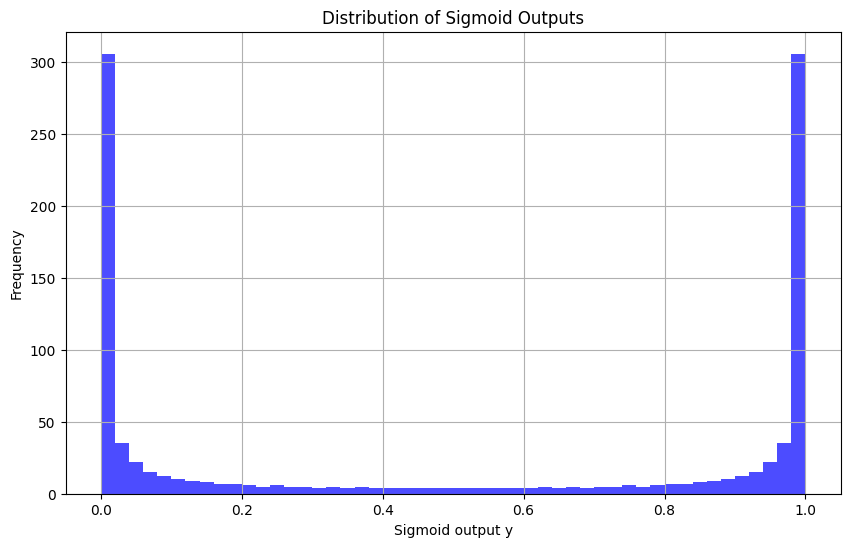

In [4]:
x = np.linspace(-10, 10, 1000) # -10부터 10까지 1000개의 값
y = sigmoid(x) # Sigmoid 함수를 사용하여 출력 데이터 계산

# y값의 분포를 히스토그램으로 시각화
plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Sigmoid Outputs')
plt.xlabel('Sigmoid output y')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

<a id="1-2"></a>
### 1-2.Vanishing gradients

In [5]:
def initialize_parameters(input_dim, hidden_dims, output_dim):
    np.random.seed(42)
    W1 = np.random.randn(hidden_dims[0], input_dim) * 0.01
    b1 = np.zeros((hidden_dims[0], 1))
    
    W2 = np.random.randn(hidden_dims[1], hidden_dims[0]) * 0.01
    b2 = np.zeros((hidden_dims[1], 1))
    
    W3 = np.random.randn(hidden_dims[2], hidden_dims[1]) * 0.01
    b3 = np.zeros((hidden_dims[2], 1))
    
    W4 = np.random.randn(output_dim, hidden_dims[2]) * 0.01
    b4 = np.zeros((output_dim, 1))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3, "W4": W4, "b4": b4}
    
    return parameters

In [6]:
def forward_propagation(X, params):
    W1, b1, W2, b2, W3, b3, W4, b4 = params['W1'], params['b1'], params['W2'], params['b2'], params['W3'], params['b3'], params['W4'], params['b4']

    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    Z4 = np.dot(W4, A3) + b4
    A4 = sigmoid(Z4)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3, Z4, A4, W4, b4)
    
    return A4, cache

In [7]:
def binary_cross_entropy(y_true, y_pred):
    m = y_true.shape[1]
    cost = -1/m * (np.dot(y_true, np.log(y_pred).T) + np.dot(1 - y_true, np.log(1 - y_pred).T))
    
    return np.squeeze(cost)

In [8]:
def backpropagation(X, Y, cache):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3, Z4, A4, W4, b4) = cache
    
    dZ4 = A4 - Y
    dW4 = 1/m * np.dot(dZ4, A3.T)
    db4 = 1/m * np.sum(dZ4, axis=1, keepdims=True)

    dA3 = np.dot(W4.T, dZ4)
    dZ3 = dA3 * A3 * (1-A3)
    dW3 = 1/m * np.dot(dZ3, A2.T)
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * A2 * (1-A2)
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * A1 * (1-A1)
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3, "dW4": dW4, "db4": db4}
    
    return gradients

In [9]:
def update_parameters(parameters, gradients, learning_rate):
    parameters["W1"] -= learning_rate * gradients["dW1"]
    parameters["b1"] -= learning_rate * gradients["db1"]
    parameters["W2"] -= learning_rate * gradients["dW2"]
    parameters["b2"] -= learning_rate * gradients["db2"]
    parameters["W3"] -= learning_rate * gradients["dW3"]
    parameters["b3"] -= learning_rate * gradients["db3"]
    parameters["W4"] -= learning_rate * gradients["dW4"]
    parameters["b4"] -= learning_rate * gradients["db4"]
    
    return parameters

In [10]:
def train_nn(X, Y, hidden_dims, num_iterations=10000, learning_rate=0.01):
    input_dim = X.shape[0]
    output_dim = Y.shape[0]
    
    parameters = initialize_parameters(input_dim, hidden_dims, output_dim)
    all_gradients = []  # List to store all gradients for plotting
    
    for i in range(num_iterations):
        # Forward Propagation
        A4, caches = forward_propagation(X, parameters)
        
        # Cost computation
        cost = binary_cross_entropy(Y, A4)
        
        # Backward Propagation
        gradients = backpropagation(X, Y, caches)
        
        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        # Record the gradient norms
        if i % 1000 == 0 or i == num_iterations - 1:  # Record at specified iterations
            gradient_norms = [np.linalg.norm(gradients[f'dW{l+1}']) for l in range(len(hidden_dims)+1)]
            all_gradients.append(gradient_norms)
            print(f"Cost after iteration {i}: {cost}")
    
    # After training, plot the gradient norms
    plt.figure(figsize=(10, 6))
    for layer in range(len(hidden_dims)+1):
        layer_gradients = [all_gradients[i][layer] for i in range(len(all_gradients))]
        plt.bar(np.array(range(len(layer_gradients))) + layer*0.1, layer_gradients, width=0.1, label=f'Layer {layer+1}')
        
    plt.title('Gradient Norms across iterations')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.show()

    return parameters


Cost after iteration 0: 0.693122555100409
Cost after iteration 1000: 0.6930752699210971
Cost after iteration 2000: 0.6930751790867564
Cost after iteration 3000: 0.6930751789122312
Cost after iteration 4000: 0.6930751789118931


Cost after iteration 5000: 0.6930751789118896
Cost after iteration 6000: 0.6930751789118869
Cost after iteration 7000: 0.6930751789118841
Cost after iteration 8000: 0.6930751789118813
Cost after iteration 9000: 0.6930751789118785
Cost after iteration 9999: 0.6930751789118758


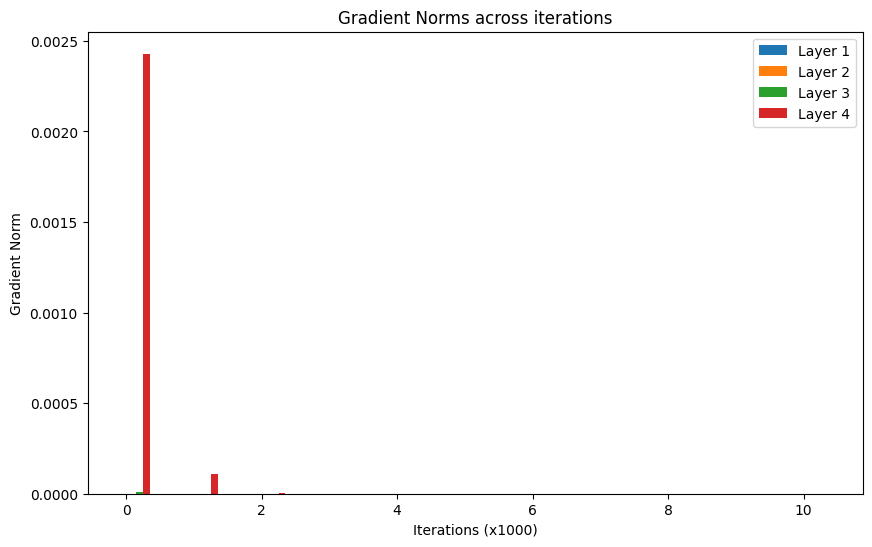

In [11]:
parameters = train_nn(train_x, train_y, hidden_dims=[4, 2, 1], num_iterations=10000, learning_rate=0.01)

<a id="2"></a>
## Tanh
$$ \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} $$

- zero center function
- sigmoid와 마찬가지로 saturated region 존재.

In [12]:
def tanh(x):
    head = np.exp(x) - np.exp(-x)
    tail = np.exp(x) + np.exp(-x)

    return head / tail

tanh 함수의 출력값(함수값)에 대한 그래프를 그려보면, 0을 중심축으로 값들이 분포되어 있는 것을 확인할 수 있다.

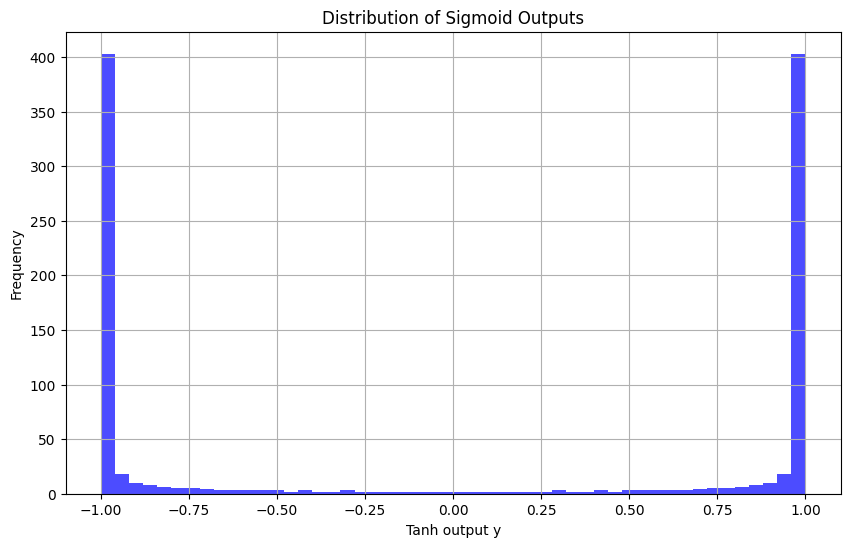

In [13]:
x = np.linspace(-10, 10, 1000)
y = tanh(x)

plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Sigmoid Outputs')
plt.xlabel('Tanh output y')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

<a id="3"></a>
## ReLU

$$ \text{ReLU}(x) = max(0, z)$$
$$
\text{ReLU}'(x) = 
\begin{cases} 
0, & \text{if } x < 0 \\
1, & \text{if } x \geq 0 
\end{cases}
$$


- 입력값이 0보다 작을 때는 0으로 출력. -> saturated region
- 1이상의 입력값은 입력값을 그대로 출력한다.(Linearity) -> non saturated region

In [14]:
def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)


In [15]:
def initialize_parameters(input_dim, hidden_dims, output_dim):
    np.random.seed(42)
    W1 = np.random.randn(hidden_dims[0], input_dim)
    b1 = np.zeros((hidden_dims[0], 1))
    
    W2 = np.random.randn(hidden_dims[1], hidden_dims[0])
    b2 = np.zeros((hidden_dims[1], 1))
    
    W3 = np.random.randn(hidden_dims[2], hidden_dims[1])
    b3 = np.zeros((hidden_dims[2], 1))
    
    W4 = np.random.randn(output_dim, hidden_dims[2])
    b4 = np.zeros((output_dim, 1))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3, "W4": W4, "b4": b4}
    
    return parameters

In [16]:
def forward_propagation(X, params):
    W1, b1, W2, b2, W3, b3, W4, b4 = params['W1'], params['b1'], params['W2'], params['b2'], params['W3'], params['b3'], params['W4'], params['b4']

    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)

    Z3 = np.dot(W3, A2) + b3
    A3 = relu(Z3)

    Z4 = np.dot(W4, A3) + b4
    A4 = relu(Z4)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3, Z4, A4, W4, b4)
    
    return A4, cache

In [17]:
def binary_cross_entropy(y_true, y_pred):
    m = y_true.shape[1]
    
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    cost = -1/m * (np.dot(y_true, np.log(y_pred).T) + np.dot(1 - y_true, np.log(1 - y_pred).T))
    
    return np.squeeze(cost)


In [18]:
def backpropagation(X, Y, cache):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3, Z4, A4, W4, b4) = cache
    
    dZ4 = A4 - Y
    dW4 = 1/m * np.dot(dZ4, A3.T)
    db4 = 1/m * np.sum(dZ4, axis=1, keepdims=True)

    dA3 = np.dot(W4.T, dZ4)
    dZ3 = dA3 * relu_derivative(dA3)
    dW3 = 1/m * np.dot(dZ3, A2.T)
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * relu_derivative(dA2)
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * relu_derivative(dA1)
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3, "dW4": dW4, "db4": db4}
    
    return gradients

In [19]:
def train_nn(X, Y, hidden_dims, num_iterations=10000, learning_rate=0.01):
    input_dim = X.shape[0]
    output_dim = Y.shape[0]
    
    parameters = initialize_parameters(input_dim, hidden_dims, output_dim)
    all_gradients = []  # List to store all gradients for plotting
    
    for i in range(num_iterations):
        # Forward Propagation
        A4, caches = forward_propagation(X, parameters)
        
        # Cost computation
        cost = binary_cross_entropy(Y, A4)
        
        # Backward Propagation
        gradients = backpropagation(X, Y, caches)
        
        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        # Record the gradient norms
        if i % 1000 == 0 or i == num_iterations - 1:  # Record at specified iterations
            gradient_norms = [np.linalg.norm(gradients[f'dW{l+1}']) for l in range(len(hidden_dims)+1)]
            all_gradients.append(gradient_norms)
            print(f"Cost after iteration {i}: {cost}")
    
    # After training, plot the gradient norms
    plt.figure(figsize=(10, 6))
    for layer in range(len(hidden_dims)+1):
        layer_gradients = [all_gradients[i][layer] for i in range(len(all_gradients))]
        plt.bar(np.array(range(len(layer_gradients))) + layer*0.1, layer_gradients, width=0.1, label=f'Layer {layer+1}')
        
    plt.title('Gradient Norms across iterations')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.show()

    return parameters


Cost after iteration 0: 11.374770359441191
Cost after iteration 1000: 0.6930751797416246
Cost after iteration 2000: 0.6930751788318449
Cost after iteration 3000: 0.6930751788318475
Cost after iteration 4000: 0.6930751788318467


Cost after iteration 5000: 0.6930751788318467
Cost after iteration 6000: 0.6930751788318467
Cost after iteration 7000: 0.6930751788318467
Cost after iteration 8000: 0.6930751788318467
Cost after iteration 9000: 0.6930751788318467
Cost after iteration 9999: 0.6930751788318467


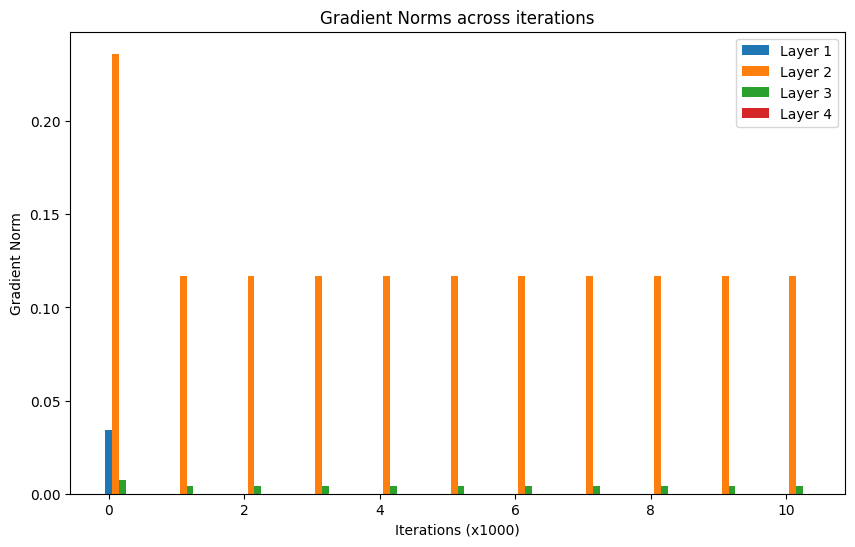

In [20]:
parameters = train_nn(train_x, train_y, hidden_dims=[4, 2, 1], num_iterations=10000, learning_rate=0.01)

<a id="4"></a>
## 4.Stochastic Gradient Descent

<a id="4-1"></a>
### 4-1.Load Dataset

In [21]:
# 데이터셋 생성
X, Y = make_moons(n_samples=6000, noise=0.3, random_state=42)

# 데이터를 학습 및 테스트 세트로 분할
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)

# Y 레이블을 (n, 1) 형태로 변환
train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

# 넘파이 배열로 변환
train_x = train_x.T
train_y = train_y.T
test_x = test_x.T
test_y = test_y.T

# 데이터 형태 확인
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)


train_x shape: (2, 4800)
train_y shape: (1, 4800)
test_x shape: (2, 1200)
test_y shape: (1, 1200)


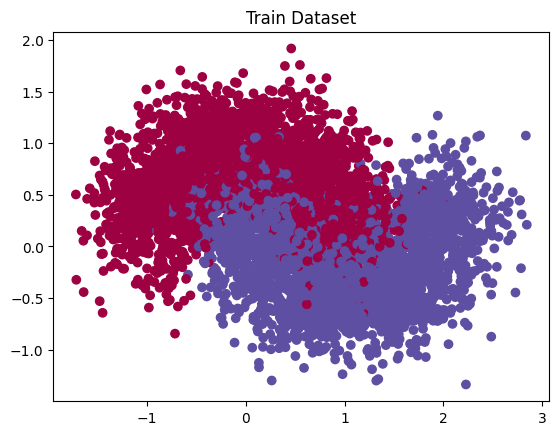

In [22]:
plt.scatter(train_x[0, :], train_x[1, :], c=train_y[0, :], cmap=plt.cm.Spectral)
plt.title("Train Dataset")
plt.show()

In [23]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []

    ## Shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    num_mini_batches = math.floor(m / mini_batch_size)
    for k in range(0, num_mini_batches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    ## 마지막 미니배치의 크기가 batch_size와 다른 경우. 나머지 데이터들을 묶어서 미니 배치를 생성.
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_mini_batches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_mini_batches * mini_batch_size:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

<a id="4-2"></a>
### 4-2.Forward & Backward with Mini-Batch

In [24]:
def initialize_parameters_random(layers_dims):
    """
    Normal Distribution을 기반으로 랜덤값을 선정.

    Arguments:
     - layer_dims : 각 layer에 설정할 unit의 수. list 타입
    
    Returns:
     - parameters : 각 layer에 설정되는 weight(matrix, "W1", "W2",..."WL"), bias(vector, "b1", "b2",..."bL")의 dictionary 타입
                    W1 : weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 : bias vector of shape (layers_dims[1], 1)
                    ...
                    WL : weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL : bias vector of shape (layers_dims[L], 1)
    """
    np.random.seed(3)

    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 10
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [25]:
def forward_propagation(X, parameters):
    """
    Arguments:
     - X : input data (n_x, m) n_x는 feature 수, m은 데이터 샘플 수
     - parameters : 각 layer의 trainable params dict타입 {"W1", "b1", ..., "WL", "bL"}

    Returns:
     - AL : 출력층(L번째 layer)의 activation feature
     - caches : 각 층의 (input, weight, bias, output)
    """
    caches = []
    A = X
    L = len(parameters) // 2
    
    # [LINEAR -> RELU]*(L-1)
    for l in range(1, L):
        A_prev = A 
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = np.dot(W, A_prev) + b
        A = np.maximum(0, Z)  # ReLU
        cache = (A_prev, W, b, Z)
        caches.append(cache)
        
    # LINEAR -> SIGMOID
    WL = parameters['W' + str(L)]
    bL = parameters['b' + str(L)]
    ZL = np.dot(WL, A) + bL
    AL = 1 / (1 + np.exp(-ZL))  # Sigmoid AL = sigmoid(ZL)
    cache = (A, WL, bL, ZL)
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

In [26]:
def compute_cost(AL, Y):
    """
    Arguments:
     - AL : label 예측에 해당하는 확률 벡터. (1, num of data samples)
     - Y : ground-truth 벡터. (1, num of data samples)

    Returns:
     - cost : cross-entropy cost
    """
    m = Y.shape[1]

    # logprobs = np.multiply(np.log(AL), Y) + np.multiply((1 - Y), np.log(1 - AL))
    logprobs = np.multiply(np.log(AL + 1e-8), Y) + np.multiply((1 - Y), np.log(1 - AL + 1e-8))

    cost = -np.sum(logprobs) / m

    cost = float(np.squeeze(cost))

    return cost

In [27]:
def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0

    return dZ

def sigmoid_backward(dA, Z):
    S = sigmoid(Z)
    dZ = dA * S * (1-S)

    return dZ

def backward_propagation(X, Y, caches, AL):
    """
    Backward Propagation.
    L-1개의 [Linear -> ReLU] layer와 출력층 [Linear -> Sigmoid]의 parameter에 대한 gradient를 계산한다.

    Arguments:
     - X : 입력 데이터. (n_x, m) n_x는 feature 수, m은 데이터 샘플의 수
     - Y : ground_truth. (1, m)
     - caches : list 타입. 각 layer의 (input, weight, bias, output).
     - AL : 마지막 출력층의 출력값. y hat.
    """
    grads = {}
    L = len(caches) ## layer 수
    m = X.shape[1] ## 데이터 샘플의 수

    ## cost function gradient
    # dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    dAL = -(np.divide(Y, AL + 1e-8) - np.divide(1 - Y, 1 - AL + 1e-8))

    ## L번째 layer(출력층) [sigmoid -> Linear] gradient
    cache = caches[-1]
    A_prev, WL, bL, ZL = cache
    dZL = sigmoid_backward(dAL, ZL) ## dL/dA * dA/dZ = dL / dZ
    dWL = np.dot(dZL, A_prev.T) ## dL/dZ * dZ/dW = dL/dW
    dbL = np.sum(dZL, axis=1, keepdims=True) / m ## dL/dZ * dZ/db = dL/db
    dA_prev = np.dot(WL.T, dZL) ## dL/dZ * dZ/dX = dL/dX

    grads["dA" + str(L)] = dA_prev
    grads["dW" + str(L)] = dWL
    grads["db" + str(L)] = dbL

    for l in reversed(range(L-1)):
        cache = caches[l]
        A_prev, W, b, Z = cache
        dZ = relu_backward(grads["dA" + str(l + 2)], Z)
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = np.dot(W.T, dZ)

        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
    
    return grads

In [28]:
def update_parameters_with_gradient_descent(parameters, grads, learning_rate):
    """
    Gradient Descent 방식으로 parameter를 업데이트.

    Arguments:
     - parameters : dict 타입. layer에 설정된 weight, bias
     - grads : dict 타입. 각 parameter에 대한 gradients
     - learning rate : 실수형. 

    Returns:
     - parameters : dict 타입. gradient로 업데이트된 parameters
    """
    L = len(parameters) // 2 ## nn을 구성하는 layer 수

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads['dW' + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads['db' + str(l)]

    return parameters

In [29]:
def model(X, Y, layers_dims, learning_rate=0.01, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_random(layers_dims)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.138454


/tmp/ipykernel_913187/580653994.py:29: RuntimeWarning: overflow encountered in exp
  AL = 1 / (1 + np.exp(-ZL))  # Sigmoid AL = sigmoid(ZL)
/tmp/ipykernel_913187/2901232116.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Cost after epoch 1000: 0.126687
Cost after epoch 2000: 0.122663
Cost after epoch 3000: 0.122455
Cost after epoch 4000: 0.120657


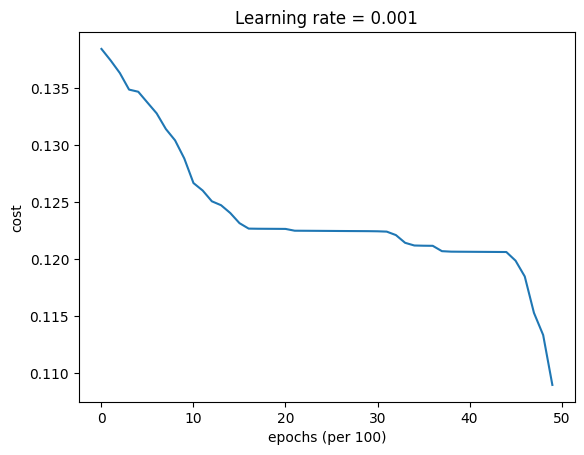

In [30]:
parameters = model(train_x, train_y, layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, batch_size=64, num_epochs=5000)

<a id="#5"></a>
## 5. SGD + Momentum

In [31]:
def initialize_velocity(parameters):
    v = {}
    L = len(parameters) // 2
    for l in range(1, L+1):
        v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
    
    return v

In [32]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L+1):
        v["dW" + str(l)] = beta * v["dW" + str(l)] + (1 - beta) * grads["dW" + str(l)]
        v["db" + str(l)] = beta * v["db" + str(l)] + (1 - beta) * grads["db" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v["db" + str(l)]  
    
    return parameters, v

In [33]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.01, beta=0.9, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_random(layers_dims)

    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            if optimizer == "gd":
                parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

/tmp/ipykernel_913187/580653994.py:29: RuntimeWarning: overflow encountered in exp
  AL = 1 / (1 + np.exp(-ZL))  # Sigmoid AL = sigmoid(ZL)
/tmp/ipykernel_913187/2901232116.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Cost after epoch 0: 0.138477


Cost after epoch 1000: 0.126468
Cost after epoch 2000: 0.122620
Cost after epoch 3000: 0.122441
Cost after epoch 4000: 0.106260


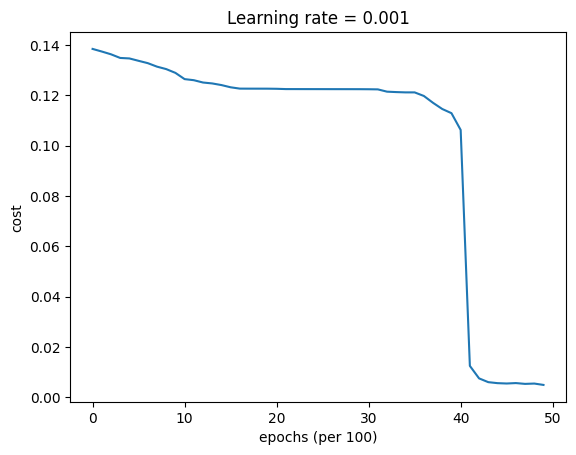

In [34]:
parameters = model(train_x, train_y, optimizer="momentum", layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, beta=0.9, num_epochs=5000)

## 6.Adagrad

In [35]:
def initialize_adagrad(parameters):
    s = {}
    L = len(parameters) // 2
    for l in range(1, L + 1):
        s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
    
    return s

In [36]:
def update_parameters_with_adagrad(parameters, grads, s, learning_rate, epsilon=1e-8):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        # 누적 제곱 그래디언트 업데이트
        s["dW" + str(l)] += np.square(grads["dW" + str(l)])
        s["db" + str(l)] += np.square(grads["db" + str(l)])
        
        # 매개변수 업데이트
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)] / (np.sqrt(s["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)] / (np.sqrt(s["db" + str(l)]) + epsilon)
    
    return parameters, s

In [37]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.01, beta=0.9, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_random(layers_dims)

    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adagrad":
        s = initialize_adagrad(parameters)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            if optimizer == "gd":
                parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adagrad":
                parameters, s = update_parameters_with_adagrad(parameters, grads, s, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

/tmp/ipykernel_913187/580653994.py:29: RuntimeWarning: overflow encountered in exp
  AL = 1 / (1 + np.exp(-ZL))  # Sigmoid AL = sigmoid(ZL)
/tmp/ipykernel_913187/2901232116.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Cost after epoch 0: 0.138522


Cost after epoch 1000: 0.137742
Cost after epoch 2000: 0.137616
Cost after epoch 3000: 0.137567
Cost after epoch 4000: 0.137545


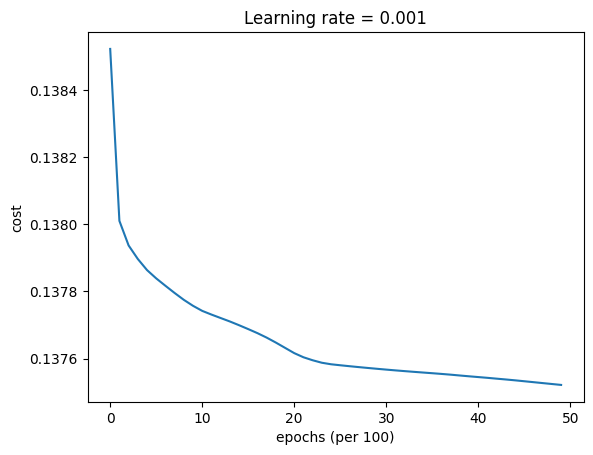

In [38]:
parameters = model(train_x, train_y, optimizer="adagrad", layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, num_epochs=5000)

## 7.RMSProp

In [39]:
def initialize_rmsprop(parameters):
    s = {}
    L = len(parameters) // 2
    for l in range(1, L + 1):
        s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
    
    return s

In [40]:
def update_parameters_with_rmsprop(parameters, grads, s, beta, learning_rate, epsilon=1e-8):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        # 가중치의 제곱 그라디언트의 이동 평균 업데이트
        s["dW" + str(l)] = beta * s["dW" + str(l)] + (1 - beta) * np.square(grads["dW" + str(l)])
        s["db" + str(l)] = beta * s["db" + str(l)] + (1 - beta) * np.square(grads["db" + str(l)])
        
        # 매개변수 업데이트
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)] / (np.sqrt(s["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)] / (np.sqrt(s["db" + str(l)]) + epsilon)
    
    return parameters, s


In [41]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.01, beta=0.9, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_random(layers_dims)

    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adagrad":
        s = initialize_adagrad(parameters)
    elif optimizer == "rmsprop":
        s = initialize_rmsprop(parameters)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            if optimizer == "gd":
                parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adagrad":
                parameters, s = update_parameters_with_adagrad(parameters, grads, s, learning_rate)
            elif optimizer == "rmsprop":
                parameters, s = update_parameters_with_rmsprop(parameters, grads, s, beta, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

/tmp/ipykernel_913187/580653994.py:29: RuntimeWarning: overflow encountered in exp
  AL = 1 / (1 + np.exp(-ZL))  # Sigmoid AL = sigmoid(ZL)
/tmp/ipykernel_913187/2901232116.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Cost after epoch 0: 0.138326


Cost after epoch 1000: 0.005234
Cost after epoch 2000: 0.005041
Cost after epoch 3000: 0.005026
Cost after epoch 4000: 0.005028


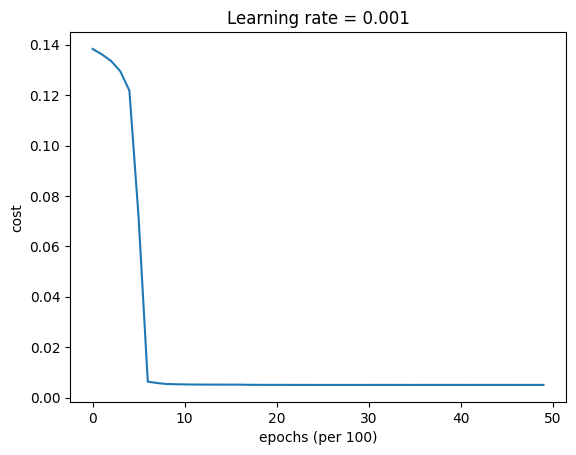

In [42]:
parameters = model(train_x, train_y, optimizer="rmsprop", layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, beta=0.9, num_epochs=5000)

## 8.Adam

In [43]:
def initialize_adam(parameters):
    v, s = {}, {}
    L = len(parameters) // 2

    for l in range(1, L+1):
        v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])

    return v, s

In [44]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}

    for l in range(1, L+1):
        ## First Moment
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]

        ## Bias correction
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - np.power(beta1, t))

        ## Second Moment
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.square(grads["dW" + str(l)])
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.square(grads["db" + str(l)]) 

        ## Bias Correction
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - np.power(beta2, t))

        ## update
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)

    return parameters, v, s, v_corrected, s_corrected

In [45]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.01, beta=0.9, beta1=0.9, beta2=0.999, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_random(layers_dims)

    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adagrad":
        s = initialize_adagrad(parameters)
    elif optimizer == "rmsprop":
        s = initialize_rmsprop(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            if optimizer == "gd":
                parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adagrad":
                parameters, s = update_parameters_with_adagrad(parameters, grads, s, learning_rate)
            elif optimizer == "rmsprop":
                parameters, s = update_parameters_with_rmsprop(parameters, grads, s, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

/tmp/ipykernel_913187/580653994.py:29: RuntimeWarning: overflow encountered in exp
  AL = 1 / (1 + np.exp(-ZL))  # Sigmoid AL = sigmoid(ZL)
/tmp/ipykernel_913187/2901232116.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Cost after epoch 0: 0.138363


Cost after epoch 1000: 0.005368
Cost after epoch 2000: 0.005171
Cost after epoch 3000: 0.005182
Cost after epoch 4000: 0.005154


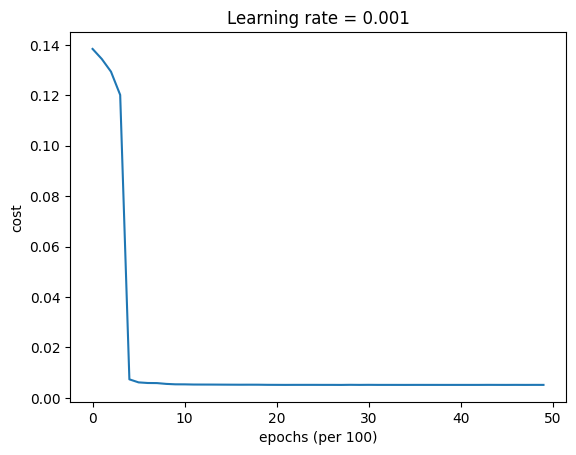

: 

In [46]:
parameters = model(train_x, train_y, optimizer="adam", layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, beta=0.9, beta1=0.9, beta2=0.999, num_epochs=5000)